# CMC Ni/Co Prediction: 

---

## 1. Problem definition

**Goal:** Predict **nickel (Ni)** and **cobalt (Co)** grade in CMC (Calcined Metal Concentrate) from time-aligned feedstock so predictions are available immediately instead of waiting ~2 days for lab results.

**Targets:** `nickel_ppm`, `cobalt_ppm` (from lab).  
**Approach:** Build features from feed window (mass-weighted Ni/Co %, quantities, ratios); fit linear (statsmodels OLS for p-values) and tree models; evaluate and check linear regression assumptions (VIF, residuals, normality, heteroskedasticity, autocorrelation).

## 2. Data collection and preparation

Build the ML feature table from raw sources (or load from cache): **LIMS** (CMC samples + lab Ni/Co), **incoming material** (feedstock transactions), **master list** (composition per item_code). Filter to CMC descriptions, join incoming to master, then for each sample build a **feed window** (residence time) and aggregate feed features. Output: **ml_table** (one row per CMC sample). Below we run this in logical order; then Section 3 uses **ml_table** (or loads from parquet) and applies ratio/feed/direct-sample filters before modeling.

<details>
<summary><strong>Step 2.1: Config and imports</strong></summary>

- **What we do:** Imports (pandas, numpy, sklearn, statsmodels, scipy, boto3, athena_connect); data prep config (PLANT_CODE, RESIDENCE_MINUTES, CMC_DESCRIPTIONS, cache paths); modeling config (PATH_ML_TABLE, TEST_FRAC, TARGETS, ratio/feed filters).
- **Results:** No output. Run this cell first.
</details>

In [14]:
# --- Imports: data, ML, stats, plotting, Athena ---
import pandas as pd
import numpy as np
import os
import sys
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

_here = os.path.abspath(os.getcwd())
if _here.endswith('notebooks'):
    sys.path.insert(0, os.path.dirname(_here))
from athena_connect import athena_query

# --- Data prep config (Section 2) ---
PLANT_CODE = '003'
RESIDENCE_MINUTES = 130   # ~2 h 10 min
FIRST_LOT_LOOKBACK_HOURS = 12
CMC_DESCRIPTIONS = ['High Nickel RC1 Calcined Metal Concentrate']
LOAD_FROM_CACHE = True   # False = refresh from Athena (e.g. new columns)
PATH_LIMS_CACHE = 'data/lims_cache.parquet'
PATH_INCOMING_CACHE = 'data/incoming_cache.parquet'
PATH_MASTER_CACHE = 'data/master_cache.parquet'
athena = boto3.client('athena', region_name='us-west-2')

# --- Path and run config (Section 3+) ---
PATH_ML_TABLE = 'data/ml_feature_table.parquet'
if not os.path.exists(PATH_ML_TABLE):
    PATH_ML_TABLE = os.path.join(os.path.dirname(os.getcwd()), 'data', 'ml_feature_table.parquet')
RANDOM_STATE = 42
TEST_FRAC = 0.2
USE_TIME_SPLIT = True   # False = random split (use to check if poor test R2 is due to time shift)
RIDGE_ALPHA = 1.0      # 0 = OLS; >0 = Ridge (can improve test R2 when train >> test)
RATIO_MIN, RATIO_MAX = 1, 100
FEED_MATCH_MIN = 0.9
USE_LOG_TARGETS = True
TARGETS = ['nickel_ppm', 'cobalt_ppm']
HOURS_MATCHED_MAX = 0   # 0 = direct samples only; None = use all
TRAIN_LAST_MONTHS = None

**Why use log for targets (and some features)?**

We set `USE_LOG_TARGETS = True` so that the model predicts **log(1 + nickel_ppm)** and **log(1 + cobalt_ppm)** instead of raw ppm. Reasons:

- **Right skew:** Lab targets (ppm) are positive and often right-skewed; log compresses large values and makes the distribution closer to symmetric, which fits OLS assumptions better.
- **Stable variance:** Variance of ppm often increases with level (e.g. higher grades more variable); log scale tends to stabilise variance (homoscedasticity).
- **Multiplicative effects:** In process data, effects are often proportional (e.g. "10% more feed Ni → ~x% more CMC Ni"); log targets turn these into additive effects that linear regression can capture.
- **Predictions:** We fit on log scale then convert back with `expm1` for MAE/RMSE in ppm.

Similarly, **log_feed_total_quantity** is used as a feature because feed quantities are positive and right-skewed; log makes the relationship with targets more linear.

<details>
<summary><strong>Step 2.2: Load source tables (LIMS, incoming, master)</strong></summary>

- **What we do:** Load from Athena (cleansed LIMS/incoming, fivetran_sharepoint master) with CMC description filter in SQL; or read from local parquet cache if LOAD_FROM_CACHE is True.
- **Results:** df_lims, df_incoming, df_master. Shapes printed.
</details>

In [15]:
use_cache = LOAD_FROM_CACHE and os.path.exists(PATH_LIMS_CACHE) and os.path.exists(PATH_INCOMING_CACHE) and os.path.exists(PATH_MASTER_CACHE)
if use_cache:
    df_lims = pd.read_parquet(PATH_LIMS_CACHE)
    df_incoming = pd.read_parquet(PATH_INCOMING_CACHE)
    df_master = pd.read_parquet(PATH_MASTER_CACHE)
    print('Loaded from local cache.')
else:
    desc_in_sql = ', '.join(f"'{d}'" for d in CMC_DESCRIPTIONS)
    lims_sql = f"""
SELECT * FROM main_fgtransaction_lims_v
WHERE plant_code = '003' AND effective_sample_id IS NOT NULL AND sample_status = 'SAMP_COMPLETED'
  AND description IN ({desc_in_sql})
"""
    df_lims = athena_query(lims_sql, 'cleansed', athena)
    df_incoming = athena_query("""SELECT * FROM incoming_material_transaction_v WHERE plant_code = '003'""", 'cleansed', athena)
    df_master = athena_query("""SELECT item_code, wt_ni_percent, wt_co_percent, cathode_chemistry FROM rc_1_battery_feedstock_master_list_master_list""", 'fivetran_sharepoint_isc_2', athena)
    os.makedirs(os.path.dirname(PATH_LIMS_CACHE) or '.', exist_ok=True)
    df_lims.to_parquet(PATH_LIMS_CACHE, index=False)
    df_incoming.to_parquet(PATH_INCOMING_CACHE, index=False)
    df_master.to_parquet(PATH_MASTER_CACHE, index=False)
    print('Loaded from Athena and saved to cache.')
print('LIMS:', df_lims.shape, 'Incoming:', df_incoming.shape, 'Master:', df_master.shape)

Loaded from local cache.
LIMS: (20259, 85) Incoming: (80007, 17) Master: (294, 4)


<details>
<summary><strong>Step 2.3: Filter to CMC samples (one per effective_sample_id)</strong></summary>

- **What we do:** Keep rows with description in CMC_DESCRIPTIONS and non-null Ni/Co; deduplicate by effective_sample_id; set lot_end_time and start_time for feed windowing.
- **Results:** samples DataFrame. One row per CMC sample.
</details>

In [17]:
# CMC description filter already applied in SQL (Step 2.2); cache holds same filtered data
lims_cmc = df_lims.copy()
lims_cmc = lims_cmc.dropna(subset=['nickel_ppm', 'cobalt_ppm'])
sample_cols = ['effective_sample_id', 'sample_id', 'start_time_local', 'end_time_local', 'transaction_time_local', 'lot_number', 'nickel_ppm', 'cobalt_ppm', 'net_weight', 'sample_type', 'description', 'item_number', 'hours_to_matched_sample']
cols_avail = [c for c in sample_cols if c in lims_cmc.columns]
samples = lims_cmc[cols_avail].drop_duplicates(subset=['effective_sample_id'], keep='first')
time_col = 'end_time_local' if 'end_time_local' in samples.columns else 'start_time_local'
samples['lot_end_time'] = pd.to_datetime(samples[time_col])
samples['start_time'] = pd.to_datetime(samples['start_time_local'])
samples = samples.sort_values('lot_end_time').reset_index(drop=True)
print('CMC samples (one per effective_sample_id):', len(samples))

CMC samples (one per effective_sample_id): 1476


<details>
<summary><strong>Step 2.4: Join incoming to master (composition + cathode_chemistry)</strong></summary>

- **What we do:** Parse incoming txn_time and quantity; join to master on item_number = item_code for wt_ni_percent, wt_co_percent, cathode_chemistry (categorical).
- **Results:** incoming_with_comp. Used in feed window aggregation.
</details>

In [20]:
df_incoming['txn_time'] = pd.to_datetime(df_incoming['transaction_time'])
df_incoming['quantity'] = pd.to_numeric(df_incoming['quantity'], errors='coerce').fillna(0)
master_cols = ['item_code', 'wt_ni_percent', 'wt_co_percent', 'cathode_chemistry']

master_comp = df_master[master_cols].copy()
master_comp['wt_ni_percent'] = pd.to_numeric(master_comp['wt_ni_percent'], errors='coerce').fillna(0)
master_comp['wt_co_percent'] = pd.to_numeric(master_comp['wt_co_percent'], errors='coerce').fillna(0)
master_comp['cathode_chemistry'] = master_comp['cathode_chemistry'].astype(str).replace('nan', np.nan)

incoming_with_comp = df_incoming.merge(master_comp, left_on='item_number', right_on='item_code', how='left')
print('Incoming rows with composition:', incoming_with_comp['item_code'].notna().sum(), 'of', len(incoming_with_comp))

Incoming rows with composition: 77718 of 80007


<details>
<summary><strong>Step 2.5: Build feed windows and ML table</strong></summary>

- **What we do:** For each sample, define time window (previous_lot_end - residence, lot_end - residence]; aggregate feed (mass-weighted Ni/Co %, total qty, item count, mass-matched %, mode cathode_chemistry). One row per sample → ml_table.
- **Results:** ml_table with feed_* columns, hour_of_day, day_of_week, shift. Optionally save to PATH_ML_TABLE.
</details>

In [21]:
# Ensure chronological order so feed windows use previous lot correctly
samples = samples.sort_values('lot_end_time', ascending=True).reset_index(drop=True)
residence_delta = timedelta(minutes=RESIDENCE_MINUTES)
first_lot_lookback = timedelta(hours=FIRST_LOT_LOOKBACK_HOURS)
rows = []
for i in range(len(samples)):
    row = samples.iloc[i]
    sample_id = row['effective_sample_id']
    lot_end = row['lot_end_time']
    t_end = lot_end - residence_delta
    if i == 0:
        t_start = t_end - first_lot_lookback
    else:
        t_start = samples.iloc[i - 1]['lot_end_time'] - residence_delta
    in_window = incoming_with_comp[(incoming_with_comp['txn_time'] > t_start) & (incoming_with_comp['txn_time'] <= t_end)]
    total_qty = in_window['quantity'].sum()
    matched = in_window.dropna(subset=['item_code'])
    matched_qty = matched['quantity'].sum()
    if total_qty == 0:
        feed_ni_pct = feed_co_pct = feed_ni_co_ratio = np.nan
        feed_mass_matched_pct = 0.0
    else:
        feed_mass_matched_pct = matched_qty / total_qty
        if matched_qty == 0:
            feed_ni_pct = feed_co_pct = feed_ni_co_ratio = np.nan
        else:
            feed_ni_pct = (matched['quantity'] * matched['wt_ni_percent']).sum() / matched_qty
            feed_co_pct = (matched['quantity'] * matched['wt_co_percent']).sum() / matched_qty
            feed_ni_co_ratio = feed_ni_pct / feed_co_pct if feed_co_pct and feed_co_pct != 0 else np.nan
    feed_item_count = in_window['item_number'].nunique()
    hours_since_prev_lot = (lot_end - samples.iloc[i - 1]['lot_end_time']).total_seconds() / 3600 if i > 0 else np.nan
    feed_cathode_chemistry = None
    if 'cathode_chemistry' in in_window.columns and len(in_window) > 0:
        cc_clean = in_window['cathode_chemistry'].dropna()
        feed_cathode_chemistry = cc_clean.mode().iloc[0] if len(cc_clean) > 0 else None
    row_dict = {'effective_sample_id': sample_id, 'sample_id': row.get('sample_id'), 'start_time_local': row['start_time_local'], 'end_time_local': row.get('end_time_local'), 'lot_number': row.get('lot_number'), 'nickel_ppm': row['nickel_ppm'], 'cobalt_ppm': row['cobalt_ppm'], 'net_weight': row.get('net_weight'), 'sample_type': row.get('sample_type'), 'feed_ni_pct_wt_avg': feed_ni_pct, 'feed_co_pct_wt_avg': feed_co_pct, 'feed_ni_co_ratio': feed_ni_co_ratio, 'feed_total_quantity': total_qty, 'feed_item_count': feed_item_count, 'feed_mass_matched_pct': feed_mass_matched_pct, 'hours_since_prev_lot': hours_since_prev_lot, 'hours_to_matched_sample': row.get('hours_to_matched_sample')}
    if feed_cathode_chemistry is not None:
        row_dict['feed_cathode_chemistry'] = feed_cathode_chemistry
    rows.append(row_dict)
ml_table = pd.DataFrame(rows)
if 'feed_cathode_chemistry' in ml_table.columns:
    ml_table['feed_cathode_chemistry'] = ml_table['feed_cathode_chemistry'].astype('category')
ml_table['hour_of_day'] = pd.to_datetime(ml_table['start_time_local']).dt.hour
ml_table['day_of_week'] = pd.to_datetime(ml_table['start_time_local']).dt.dayofweek
ml_table['shift'] = (ml_table['hour_of_day'] >= 6) & (ml_table['hour_of_day'] < 18)
os.makedirs(os.path.dirname(PATH_ML_TABLE) or '.', exist_ok=True)
ml_table.to_parquet(PATH_ML_TABLE, index=False)
print('ML feature table:', ml_table.shape, '| Saved to', PATH_ML_TABLE)

ML feature table: (1476, 21) | Saved to data/ml_feature_table.parquet


## 3. Data processing

Use **ml_table** from above (or load from parquet if you skipped Section 2). Apply ratio, feed-match, and direct-sample filters; then explore, clean, encode, correlate, split, and normalise.

<details>
<summary><strong>Step 1: Import the necessary libraries</strong></summary>

- Already done in Step 2.1. No extra cell needed.
</details>

<details>
<summary><strong>Step 2: Load the dataset and apply filters</strong></summary>

- **What we do:** Use ml_table from Section 2 (in memory) or load from PATH_ML_TABLE; filter by ratio (1–100), feed match (≥ 90%), direct lab matches (hours_to_matched_sample ≤ 0), optional last N months; sort by time.
- **Results:** df. Table shape and first rows.
</details>

In [22]:
# Use ml_table from Section 2 if in memory, else load from parquet
if 'ml_table' in dir() and ml_table is not None:
    df = ml_table.copy()
else:
    df = pd.read_parquet(PATH_ML_TABLE)
if 'start_time' not in df.columns:
    df['start_time'] = pd.to_datetime(df['start_time_local'])
# Ratio filter: keep 1 <= feed_qty/net_weight <= 100 (removes bad attribution)
ratio_raw = df['feed_total_quantity'] / df['net_weight'].replace(0, np.nan)
ratio_raw = ratio_raw.replace([np.inf, -np.inf], np.nan)
ratio_clean = ratio_raw[(ratio_raw >= RATIO_MIN) & (ratio_raw <= RATIO_MAX)]
df = df.loc[ratio_clean.index].copy()
# Keep only rows where most feed mass matched to master list
if 'feed_mass_matched_pct' in df.columns and FEED_MATCH_MIN > 0:
    matched = (df['feed_mass_matched_pct'].fillna(0) >= FEED_MATCH_MIN)
    df = df[matched].copy()
# Direct lab matches only (reduces label noise)
if 'hours_to_matched_sample' in df.columns and HOURS_MATCHED_MAX is not None:
    direct = (df['hours_to_matched_sample'].fillna(np.inf) <= HOURS_MATCHED_MAX)
    df = df[direct].copy()
# Optional: restrict to last N months
if TRAIN_LAST_MONTHS is not None:
    cutoff = df['start_time'].max() - pd.DateOffset(months=TRAIN_LAST_MONTHS)
    df = df[df['start_time'] >= cutoff].copy()
df = df.sort_values('start_time').reset_index(drop=True)
print('Shape:', df.shape)
df.head()

Shape: (1105, 22)


,effective_sample_id,sample_id,start_time_local,end_time_local,lot_number,nickel_ppm,cobalt_ppm,net_weight,sample_type,feed_ni_pct_wt_avg,...,feed_total_quantity,feed_item_count,feed_mass_matched_pct,hours_since_prev_lot,hours_to_matched_sample,feed_cathode_chemistry,hour_of_day,day_of_week,shift,start_time
0,AA33486,AA33486,2024-04-06 05:59:27,2024-04-06 07:00:55,0030262404060001-1,288582.2,71656.8,757.0,single,0.093513,...,19225.0,5,1.0,NaN,0.000000,LCO,5,5,False,2024-04-06 05:59:27
1,AA33639,AA33639,2024-04-07 06:00:53,2024-04-07 06:56:44,0030262404070001-14,350103.2,34512.0,816.0,single,0.190781,...,2817.0,2,1.0,2.039444,0.000000,NCA,6,6,True,2024-04-07 06:00:53
2,AA33645,AA33645,2024-04-07 10:41:03,2024-04-07 11:09:11,0030262404070001-20,347889.7,32294.2,766.0,inferred_single,0.072728,...,11806.0,4,1.0,4.207500,-3.472778,NCA,10,6,True,2024-04-07 10:41:03
3,AA33708,AA33708,2024-04-07 19:15:23,2024-04-07 19:29:30,0030262404070001-32,314700.6,36990.4,696.0,inferred_single,0.136225,...,14514.0,4,1.0,8.338611,-0.581944,NCA,19,6,False,2024-04-07 19:15:23
4,AA33976,AA33976,2024-04-09 19:50:54,2024-04-09 20:37:08,0030262404090001-36,219817.2,52352.2,741.0,inferred_single,0.113844,...,51445.0,3,1.0,19.763056,-13.768888,NMC,19,1,False,2024-04-09 19:50:54


<details>
<summary><strong>Step 3: Explore the dataset (EDA)</strong></summary>

- **What we do:** Inspect the data with **head**, **info**, **describe**, **null counts**, **unique values** (object/category), and **box plots** for numeric columns to spot missing values, ranges, skew, and outliers before modeling.
- **Results:** Use this to decide cleaning and feature choices.
</details>

In [78]:
# Head
print('First rows (head):')
display(df.head())

First rows (head):


,effective_sample_id,sample_id,start_time_local,end_time_local,lot_number,nickel_ppm,cobalt_ppm,net_weight,sample_type,feed_ni_pct_wt_avg,...,feed_total_quantity,feed_item_count,feed_mass_matched_pct,hours_since_prev_lot,hours_to_matched_sample,feed_cathode_chemistry,hour_of_day,day_of_week,shift,start_time
0,AA33486,AA33486,2024-04-06 05:59:27,2024-04-06 07:00:55,0030262404060001-1,288582.2,71656.8,757.0,single,0.093513,...,19225.0,5,1.0,NaN,0.000000,LCO,5,5,False,2024-04-06 05:59:27
1,AA33639,AA33639,2024-04-07 06:00:53,2024-04-07 06:56:44,0030262404070001-14,350103.2,34512.0,816.0,single,0.190781,...,2817.0,2,1.0,2.039444,0.000000,NCA,6,6,True,2024-04-07 06:00:53
2,AA33645,AA33645,2024-04-07 10:41:03,2024-04-07 11:09:11,0030262404070001-20,347889.7,32294.2,766.0,inferred_single,0.072728,...,11806.0,4,1.0,4.207500,-3.472778,NCA,10,6,True,2024-04-07 10:41:03
3,AA33708,AA33708,2024-04-07 19:15:23,2024-04-07 19:29:30,0030262404070001-32,314700.6,36990.4,696.0,inferred_single,0.136225,...,14514.0,4,1.0,8.338611,-0.581944,NCA,19,6,False,2024-04-07 19:15:23
4,AA33976,AA33976,2024-04-09 19:50:54,2024-04-09 20:37:08,0030262404090001-36,219817.2,52352.2,741.0,inferred_single,0.113844,...,51445.0,3,1.0,19.763056,-13.768888,NMC,19,1,False,2024-04-09 19:50:54


In [79]:
# Info (dtypes, non-null counts)
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1105 entries, 0 to 1104
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   effective_sample_id      1105 non-null   str           
 1   sample_id                1105 non-null   str           
 2   start_time_local         1105 non-null   str           
 3   end_time_local           1105 non-null   str           
 4   lot_number               1105 non-null   str           
 5   nickel_ppm               1105 non-null   float64       
 6   cobalt_ppm               1105 non-null   float64       
 7   net_weight               1105 non-null   float64       
 8   sample_type              1105 non-null   str           
 9   feed_ni_pct_wt_avg       1105 non-null   float64       
 10  feed_co_pct_wt_avg       1105 non-null   float64       
 11  feed_ni_co_ratio         1104 non-null   float64       
 12  feed_total_quantity      1105 non-null   floa

In [80]:
# Describe (summary stats for numeric columns)
display(df.describe())

,nickel_ppm,cobalt_ppm,net_weight,feed_ni_pct_wt_avg,feed_co_pct_wt_avg,feed_ni_co_ratio,feed_total_quantity,feed_item_count,feed_mass_matched_pct,hours_since_prev_lot,hours_to_matched_sample,hour_of_day,day_of_week,start_time
count,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1104.000000,1105.000000,1105.000000,1105.000000,1104.000000,1105.000000,1105.000000,1105.000000,1105
mean,261512.031991,46744.679276,831.673665,0.141219,0.025895,7.850882,21760.412679,9.179186,0.991240,7.893389,-0.303128,11.637104,3.370136,2025-06-29 03:54:04.214479
min,43593.600000,1494.300000,328.000000,0.000000,0.000000,0.074738,811.000000,1.000000,0.900048,0.234167,-14.233055,0.000000,0.000000,2024-04-06 05:59:27
25%,213063.500000,29052.200000,799.500000,0.113470,0.014342,3.602689,6274.000000,4.000000,1.000000,1.971319,0.000000,5.000000,2.000000,2025-01-14 10:46:59
50%,263798.500000,40613.600000,817.200012,0.140546,0.022599,5.688564,15202.000000,8.000000,1.000000,5.707083,0.000000,12.000000,4.000000,2025-10-03 18:21:24
75%,318195.500000,59520.800000,866.000000,0.171973,0.032942,10.998012,33886.000000,12.000000,1.000000,11.973889,0.000000,18.000000,5.000000,2025-12-19 23:11:32
max,438901.400000,165345.600000,1109.000000,0.292000,0.155770,21.576471,93367.000000,50.000000,1.000000,119.548333,0.000000,23.000000,6.000000,2026-02-14 23:28:35
std,68422.901511,23274.413173,73.245348,0.042635,0.015669,5.582190,19282.824761,6.497527,0.020075,8.116710,1.317734,7.187416,1.888086,NaN


In [81]:
# Null values
null_counts = df.isnull().sum()
null_pct = (df.isnull().sum() / len(df) * 100).round(2)
null_df = pd.DataFrame({'null_count': null_counts, 'null_pct': null_pct})
null_df = null_df[null_df['null_count'] > 0].sort_values('null_count', ascending=False)
if len(null_df) > 0:
    display(null_df)
else:
    print('No null values.')

,null_count,null_pct
feed_ni_co_ratio,1,0.09
hours_since_prev_lot,1,0.09
feed_cathode_chemistry,1,0.09


In [92]:
# Unique values (object and category columns)
obj_cat = [c for c in df.columns if df[c].dtype == object or (hasattr(df[c].dtype, 'name') and df[c].dtype.name == 'category')]
if obj_cat:
    for c in obj_cat:
        n = df[c].nunique()
        vals = df[c].dropna().unique()[:].tolist()
        print(f"{c}: n_unique={n}, sample: {vals}")
else:
    print('No object/category columns.')

feed_cathode_chemistry: n_unique=9, sample: ['LCO', 'NCA', 'NMC', 'Mixed', 'NMC/NCA', 'LFP', '?', 'Primaries', 'LCO?']


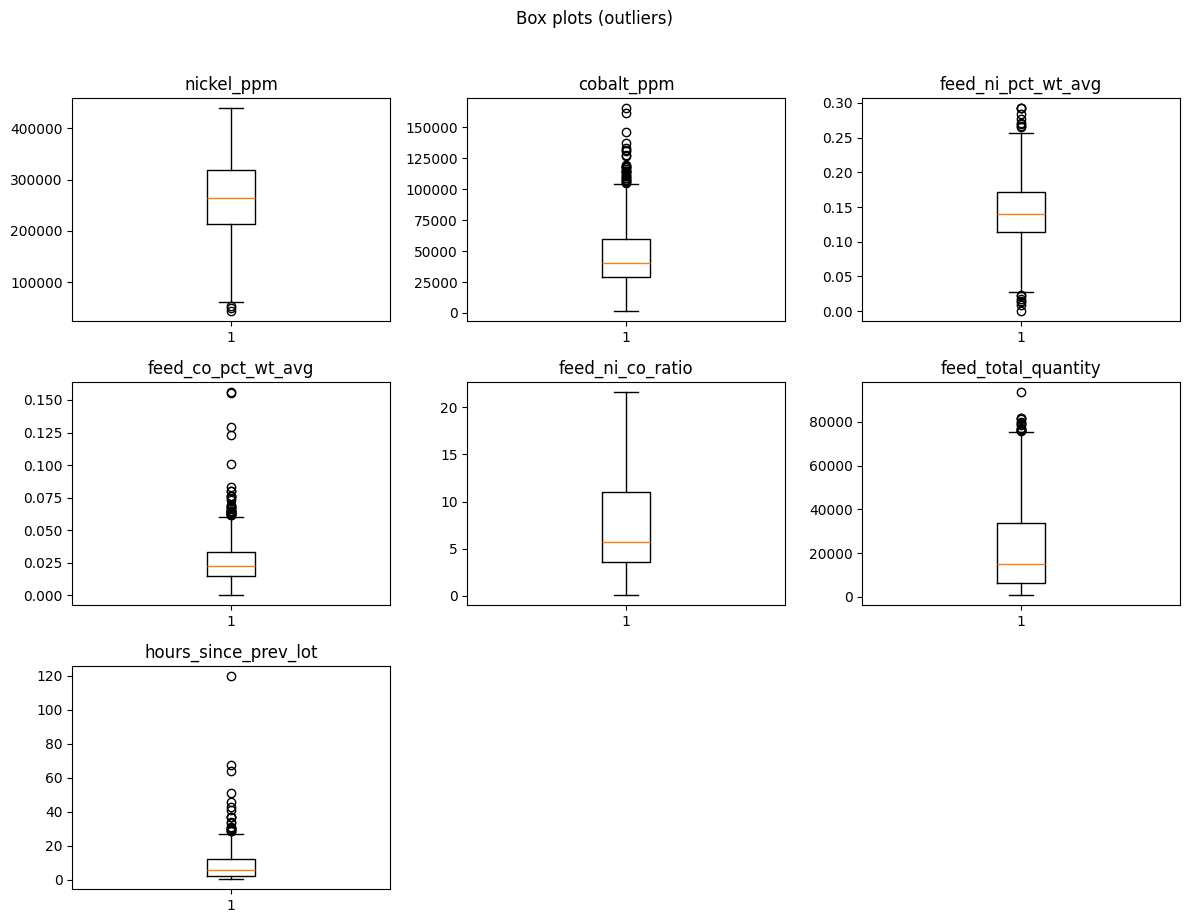

In [84]:
# Box plots (outliers): targets + key features
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
plot_cols = [c for c in (TARGETS + ['feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'feed_ni_co_ratio', 'feed_total_quantity', 'hours_since_prev_lot']) if c in num_cols]
if not plot_cols:
    plot_cols = num_cols[:10]
n_plot = len(plot_cols)
n_cols = 3
n_rows = (n_plot + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = np.atleast_2d(axes)
for i, col in enumerate(plot_cols):
    r, c = i // n_cols, i % n_cols
    axes[r, c].boxplot(df[col].dropna(), vert=True)
    axes[r, c].set_title(col)
    axes[r, c].set_ylabel('')
for i in range(len(plot_cols), axes.size):
    r, c = i // n_cols, i % n_cols
    axes[r, c].set_visible(False)
plt.suptitle('Box plots (outliers)', y=1.02)
plt.tight_layout()
plt.show()

<details>
<summary><strong>Step 4: Statistical analysis</strong></summary>

- **What we do:** Summary stats for targets (Ni, Co ppm) and for the feed/lot ratio.
- **Results:** Check mean and spread of targets; ratio stats should look plausible (e.g. mean ratio in low tens).
</details>

In [24]:
# Identify numeric columns (avoids error with string dtypes)
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
# Target summaries: mean, std, min, max for Ni and Co (ppm)
print('Summary stats for targets:')
print(df[TARGETS].describe().round(2))
# Ratio distribution (should be in [1, 100] after filter)
print('\nRatio (feed_total_quantity / net_weight):')
r = df['feed_total_quantity'] / df['net_weight'].replace(0, np.nan)
print(r.describe())

Summary stats for targets:
       nickel_ppm  cobalt_ppm
count     1105.00     1105.00
mean    261512.03    46744.68
std      68422.90    23274.41
min      43593.60     1494.30
25%     213063.50    29052.20
50%     263798.50    40613.60
75%     318195.50    59520.80
max     438901.40   165345.60

Ratio (feed_total_quantity / net_weight):
count    1105.000000
mean       26.564703
std        23.728088
min         1.022054
25%         7.406369
50%        18.710814
75%        40.844828
max        98.075030
dtype: float64


<details>
<summary><strong>Step 5: Check the outliers</strong></summary>

- **What we do:** Drop rows with null targets; optionally clip Ni/Co to 99th percentile to reduce impact of extreme lab values (WINSORIZE_TARGETS).
- **Results:** Row count after cleanup. If you enable winsorize, counts stay the same but extreme highs are capped.
</details>

In [5]:
# Clip values above percentile (e.g. 99) to limit outlier impact
def clip_outliers(df_in, columns, percentile=99):
    out = df_in.copy()
    for col in columns:
        if col not in out.columns:
            continue
        upper = np.nanpercentile(out[col], percentile)
        out[col] = np.clip(out[col], a_min=None, a_max=upper)
    return out

WINSORIZE_TARGETS = False
df_clean = df.dropna(subset=TARGETS).copy()
if WINSORIZE_TARGETS:
    df_clean = clip_outliers(df_clean, TARGETS, percentile=99)
print('Rows after dropping null targets:', len(df_clean))

Rows after dropping null targets: 1043


<details>
<summary><strong>Step 6: Encoding</strong></summary>

- **What we do:** Add **log_feed_total_quantity** and define the feature set: composition (**feed_ni_pct_wt_avg**, **feed_co_pct_wt_avg**), scale (**log_feed_total_quantity**), **feed_ni_co_ratio** (Ni:Co balance).
- **Results:** FEATURE_COLS (4 features) used in modeling.
</details>

In [66]:
# Feature set: composition, scale, Ni:Co balance (no hours_since_prev_lot)
df_clean['log_feed_total_quantity'] = np.log1p(df_clean['feed_total_quantity'])
FEATURE_COLS = [
    'feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'log_feed_total_quantity',
    'feed_ni_co_ratio',   # Ni:Co balance in feed
]
FEATURE_COLS = [c for c in FEATURE_COLS if c in df_clean.columns]
print('Features for modeling:', FEATURE_COLS)

Features for modeling: ['feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'log_feed_total_quantity', 'feed_ni_co_ratio', 'hours_since_prev_lot']


**Box plots after logs and clips** — Distributions after applying log to targets and winsorizing (1st/99th percentile) to targets and key features. Compare with the EDA box plots above to see the effect of transforms.

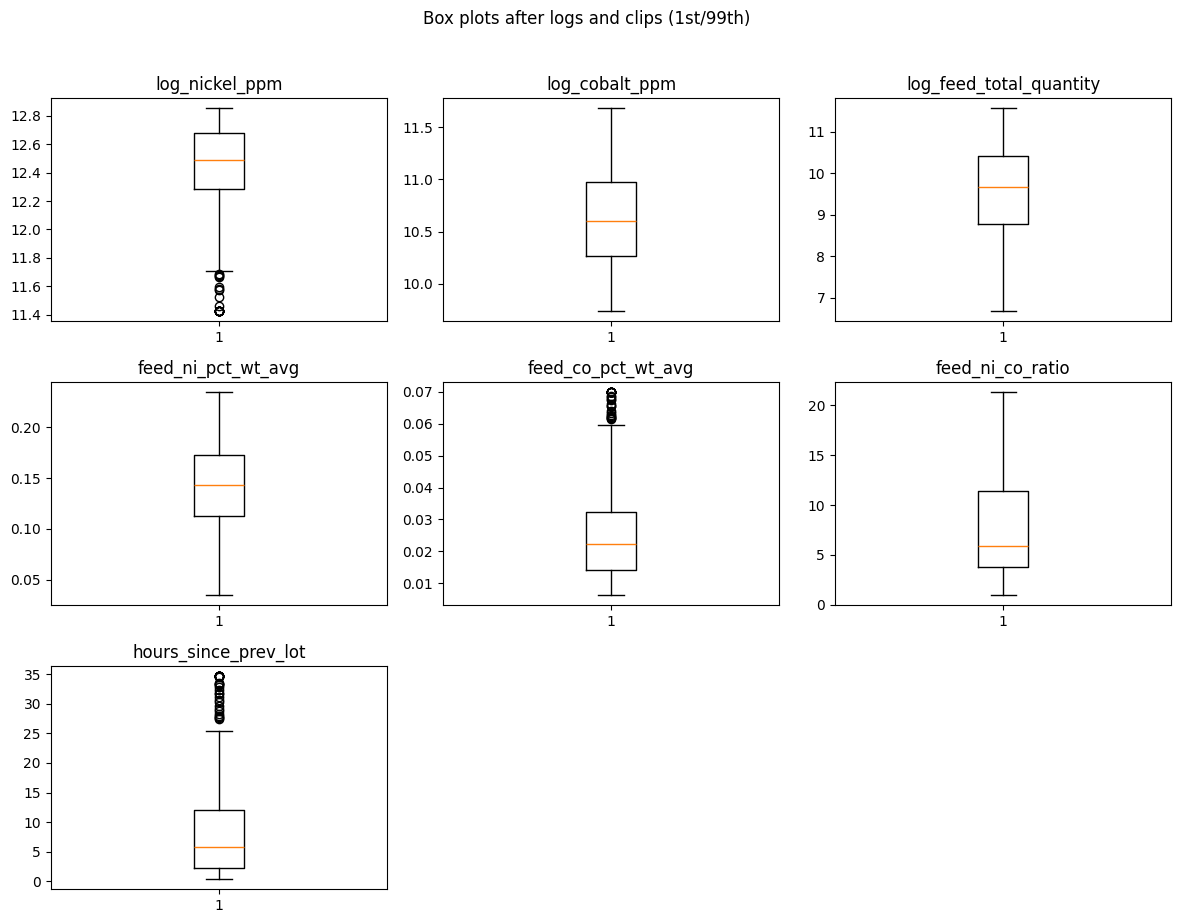

In [85]:
# Winsorize at 1st and 99th percentile (for display; does not modify df_clean)
def winsorize_1_99(df_in, columns, p_low=1, p_high=99):
    out = df_in.copy()
    for col in columns:
        if col not in out.columns:
            continue
        lo = np.nanpercentile(out[col], p_low)
        hi = np.nanpercentile(out[col], p_high)
        out[col] = np.clip(out[col], lo, hi)
    return out

cols_clip = TARGETS + ['feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'feed_ni_co_ratio', 'hours_since_prev_lot']
cols_clip = [c for c in cols_clip if c in df_clean.columns]
df_plot = winsorize_1_99(df_clean, cols_clip)

# Build display columns: log targets (from clipped ppm), log_feed_total_quantity, clipped features
plot_data = pd.DataFrame()
plot_data['log_nickel_ppm'] = np.log1p(df_plot['nickel_ppm'])
plot_data['log_cobalt_ppm'] = np.log1p(df_plot['cobalt_ppm'])
plot_data['log_feed_total_quantity'] = df_plot['log_feed_total_quantity']
for c in ['feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'feed_ni_co_ratio', 'hours_since_prev_lot']:
    if c in df_plot.columns:
        plot_data[c] = df_plot[c]

plot_cols = [c for c in plot_data.columns]
n_plot = len(plot_cols)
n_cols = 3
n_rows = (n_plot + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = np.atleast_2d(axes)
for i, col in enumerate(plot_cols):
    r, c = i // n_cols, i % n_cols
    axes[r, c].boxplot(plot_data[col].dropna(), vert=True)
    axes[r, c].set_title(col)
    axes[r, c].set_ylabel('')
for i in range(len(plot_cols), axes.size):
    r, c = i // n_cols, i % n_cols
    axes[r, c].set_visible(False)
plt.suptitle('Box plots after logs and clips (1st/99th)', y=1.02)
plt.tight_layout()
plt.show()

<details>
<summary><strong>Step 7: Correlation</strong></summary>

- **What we do:** Compute correlation of each feature (minimal set: feed_ni_pct_wt_avg, feed_co_pct_wt_avg, log_feed_total_quantity) with nickel_ppm and cobalt_ppm.
- **Results:** Table of correlations and heatmaps.
</details>

Correlation of features with targets:


,nickel_ppm,cobalt_ppm
feed_ni_pct_wt_avg,0.604,-0.422
feed_co_pct_wt_avg,-0.353,0.408
log_feed_total_quantity,0.374,-0.130
feed_ni_co_ratio,0.511,-0.478
hours_since_prev_lot,0.269,-0.135


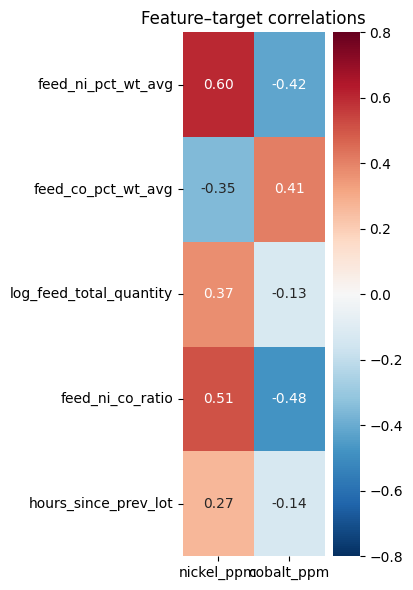

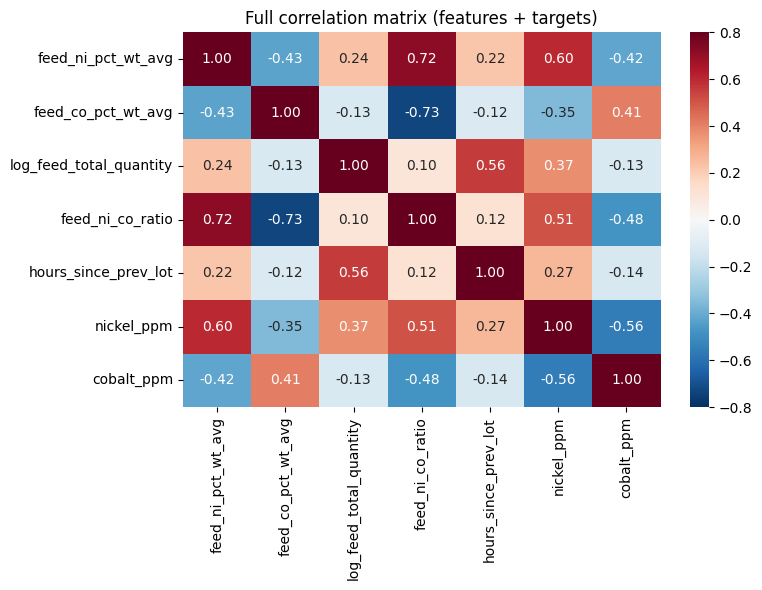

In [86]:
# Correlation of minimal feature set with targets
num_cols = [c for c in FEATURE_COLS if c in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[c])]
data_corr = df_clean[num_cols + TARGETS].dropna(how='all', subset=num_cols)
corr_ni = data_corr[num_cols].corrwith(data_corr['nickel_ppm'])
corr_co = data_corr[num_cols].corrwith(data_corr['cobalt_ppm'])
corr_df = pd.DataFrame({'nickel_ppm': corr_ni, 'cobalt_ppm': corr_co})
print('Correlation of features with targets:')
display(corr_df.round(3))

fig, ax = plt.subplots(figsize=(4, max(6, len(corr_df) * 0.35)))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax, vmin=-0.8, vmax=0.8)
ax.set_title('Feature–target correlations')
plt.tight_layout()
plt.show()

corr_full = data_corr[num_cols + TARGETS].corr()
fig2, ax2 = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_full, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax2, vmin=-0.8, vmax=0.8)
ax2.set_title('Full correlation matrix (features + targets)')
plt.tight_layout()
plt.show()

**Feed mass matched %** — Fraction of feed in each sample’s window that had known composition (item matched to master). Higher values mean more reliable feed features for that row.

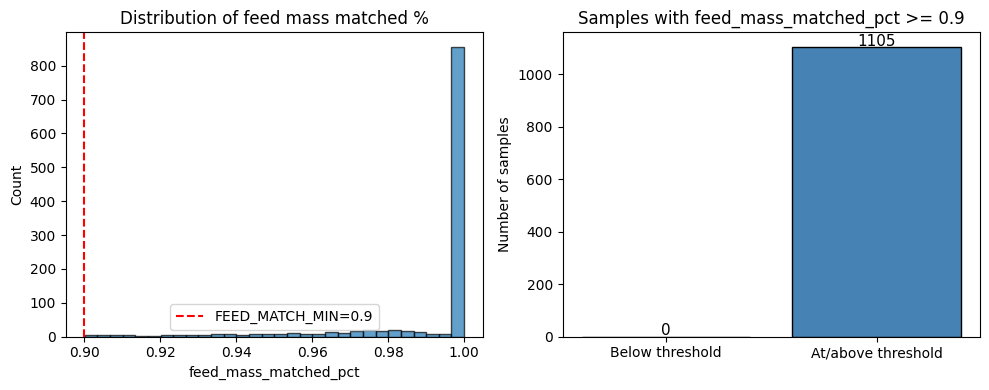

In [93]:
# Plot feed_mass_matched_pct (ratio of feed with known composition per sample)
if 'feed_mass_matched_pct' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    x = df['feed_mass_matched_pct'].fillna(0)
    axes[0].hist(x, bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(FEED_MATCH_MIN, color='red', linestyle='--', label=f'FEED_MATCH_MIN={FEED_MATCH_MIN}')
    axes[0].set_xlabel('feed_mass_matched_pct')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of feed mass matched %')
    axes[0].legend()
    # Bar: share of samples above vs below threshold
    above = (x >= FEED_MATCH_MIN).sum()
    below = len(x) - above
    axes[1].bar(['Below threshold', 'At/above threshold'], [below, above], color=['coral', 'steelblue'], edgecolor='black')
    axes[1].set_ylabel('Number of samples')
    axes[1].set_title(f'Samples with feed_mass_matched_pct >= {FEED_MATCH_MIN}')
    for i, v in enumerate([below, above]):
        axes[1].text(i, v + 5, str(v), ha='center', fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print('feed_mass_matched_pct not in df')

**Pair plots** — Scatter matrix of features and targets (same data as correlation). Use to inspect relationships and bivariate distributions.

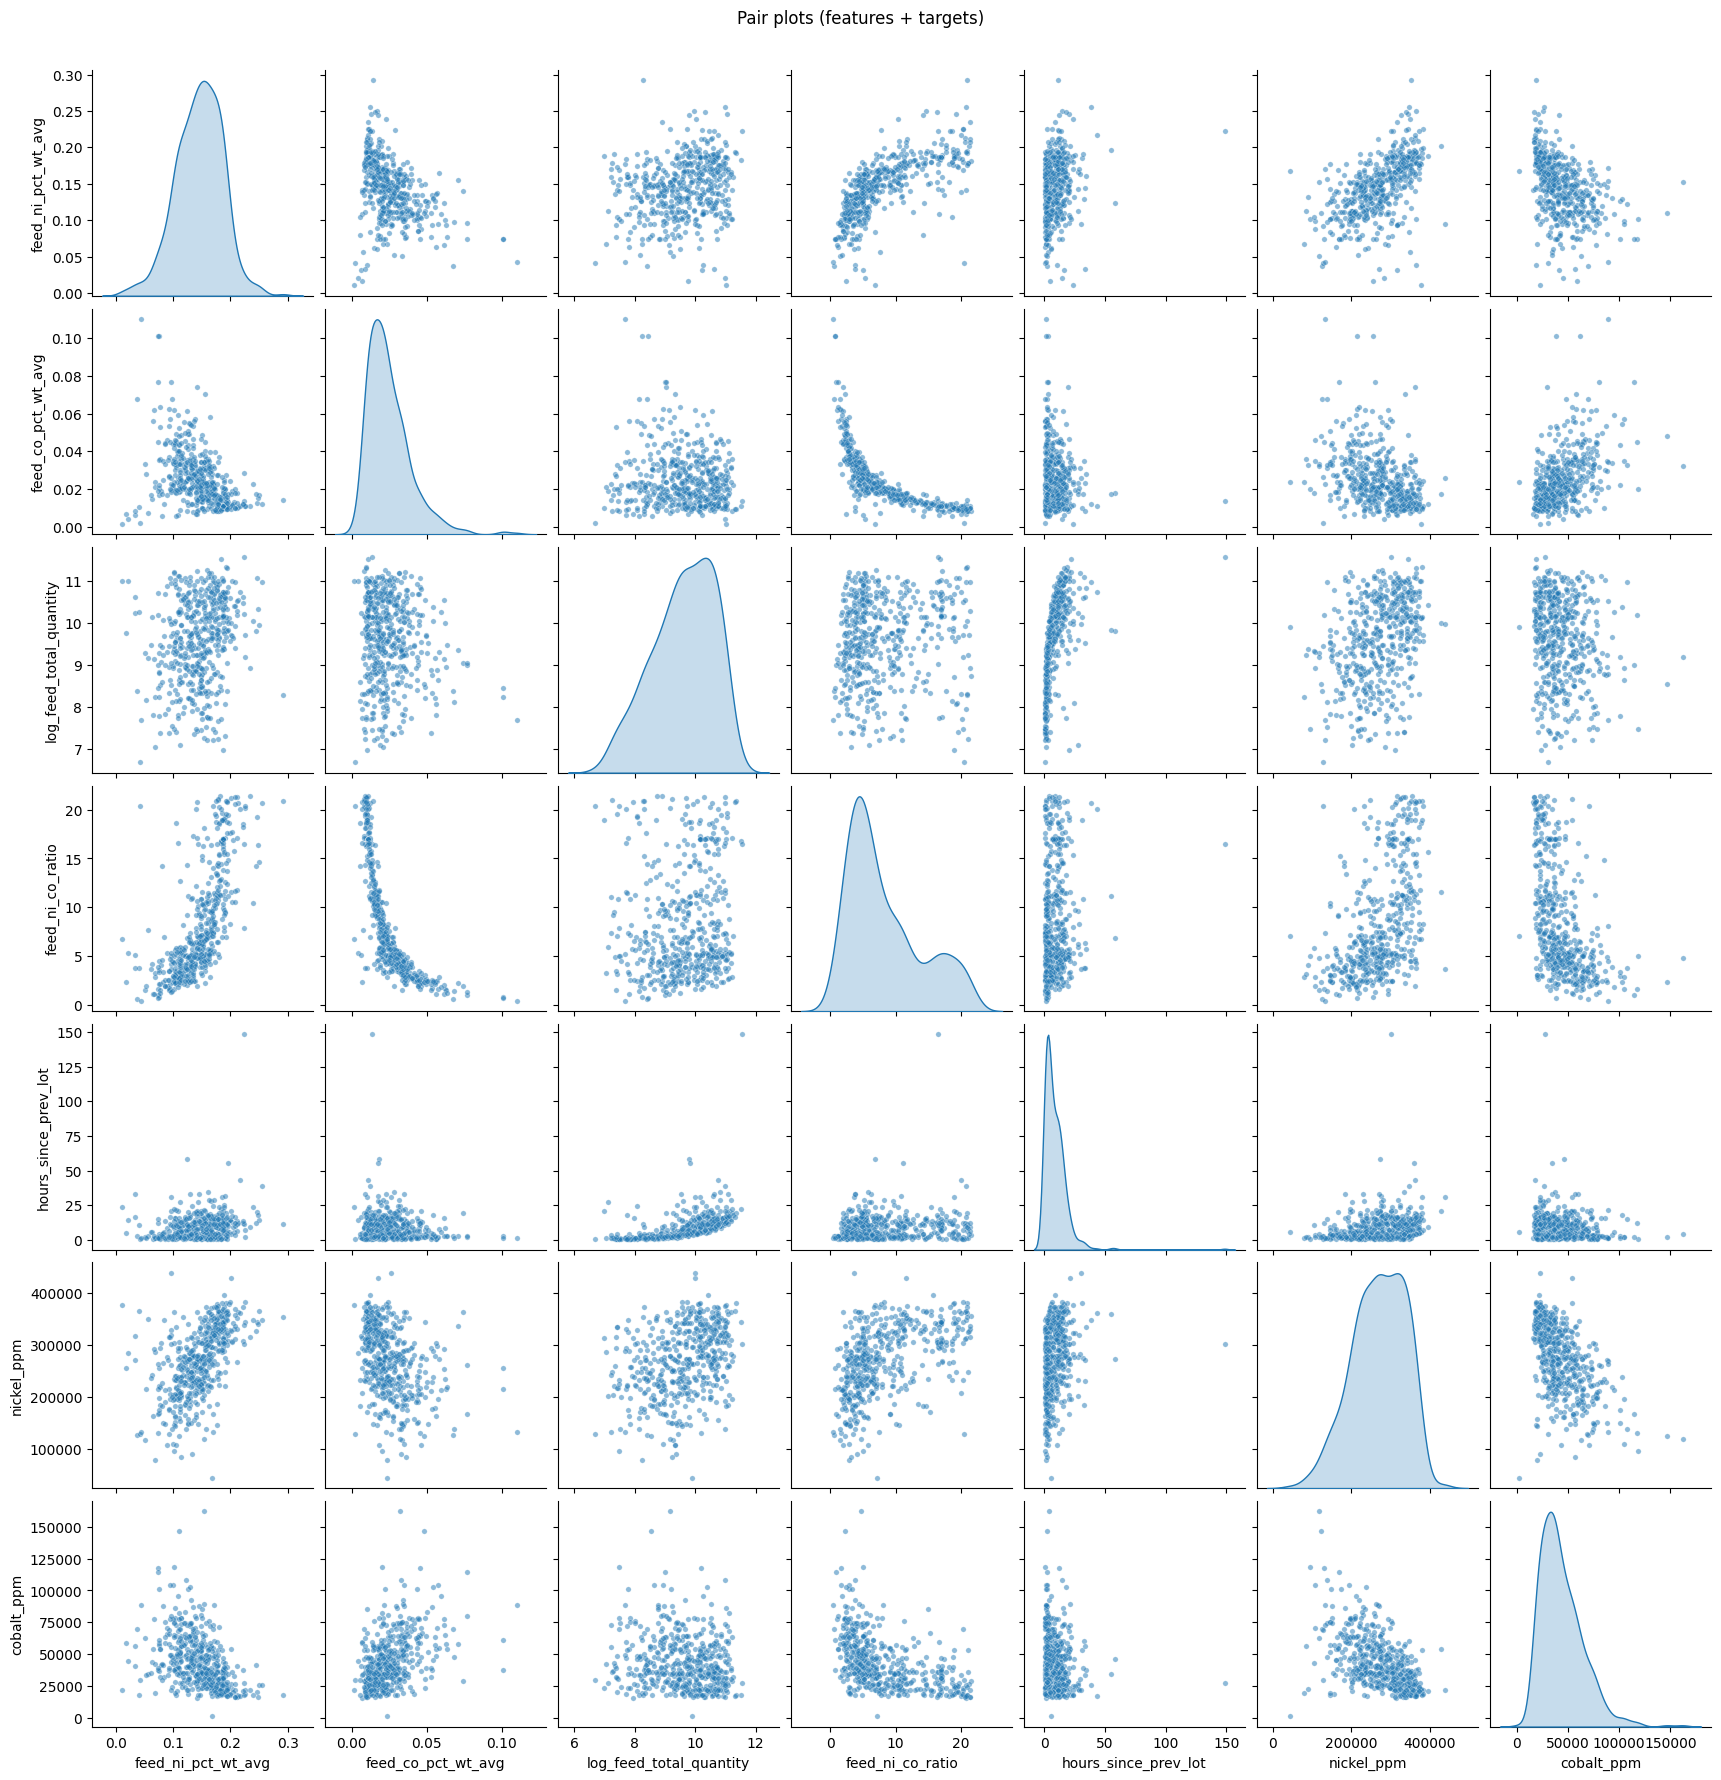

In [87]:
# Pair plots: features + targets (sample if large for speed)
pair_cols = [c for c in (num_cols + TARGETS) if c in data_corr.columns]
pair_df = data_corr[pair_cols].dropna()
if len(pair_df) > 500:
    pair_df = pair_df.sample(500, random_state=RANDOM_STATE)
sns.pairplot(pair_df, diag_kind='kde', plot_kws={'alpha': 0.5, 's': 15})
plt.suptitle('Pair plots (features + targets)', y=1.02)
plt.show()

<details>
<summary><strong>Step 8: Separate independent features and target variables</strong></summary>

- **What we do:** Build X (features) and y (targets); drop rows with any missing in X or y; keep time order for a correct time-based train/test split.
- **Results:** Shapes of X_clean and y_clean. Fewer rows than df_clean if there are NaNs in features.
</details>

In [68]:
# Independent (X) and target (y) from cleaned dataframe
X = df_clean[FEATURE_COLS].copy()
y = df_clean[TARGETS].copy()
# Drop rows with any missing in X or y
valid = X.dropna(how='any').index.intersection(y.dropna(how='any').index)
# Sort by time so train = first (1-TEST_FRAC), test = last TEST_FRAC
if 'start_time' in df_clean.columns:
    valid_sorted = df_clean.loc[valid].sort_values('start_time').index
else:
    valid_sorted = valid
X_clean = X.loc[valid_sorted]
y_clean = y.loc[valid_sorted]
print('Independent (X) shape:', X_clean.shape)
print('Targets (y) shape:', y_clean.shape)

Independent (X) shape: (1040, 5)
Targets (y) shape: (1040, 2)


<details>
<summary><strong>Step 9: Train/test split, imputation and normalisation</strong></summary>

- **What we do:** Time-based train/test split (first 80% train, last 20% test by time); impute missing values (median) and standardise (zero mean, unit variance) using **training data only** to avoid leakage.
- **Results:** Train and test sizes. Scaled matrices (X_train_scaled, X_test_scaled) and target DataFrames (y_train_df, y_test_df) are used in VIF, OLS, and evaluation.
</details>

In [69]:
# Train/test split: time-based (last TEST_FRAC) or random
n_test = int(len(X_clean) * TEST_FRAC)
n_train = len(X_clean) - n_test
idx = np.arange(len(X_clean))
if USE_TIME_SPLIT:
    train_idx = X_clean.index[:n_train]
    test_idx = X_clean.index[n_train:]
else:
    np.random.seed(RANDOM_STATE)
    np.random.shuffle(idx)
    train_idx = X_clean.index[idx[:n_train]]
    test_idx = X_clean.index[idx[n_train:]]
X_train_raw = X_clean.loc[train_idx]
X_test_raw = X_clean.loc[test_idx]
y_train_df = y_clean.loc[train_idx]
y_test_df = y_clean.loc[test_idx]
# Impute missing (median) and scale; fit on train only to avoid leakage
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp = imputer.transform(X_test_raw)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
print('Train:', X_train_scaled.shape[0], 'Test:', X_test_scaled.shape[0])
print('Split:', 'time-based' if USE_TIME_SPLIT else 'random (seed={})'.format(RANDOM_STATE))
print('Normalisation (StandardScaler) fitted on train only.')

Train: 832 Test: 208
Normalisation (StandardScaler) fitted on train only.


<details>
<summary><strong>4. VIF (multicollinearity)</strong></summary>

- **What we do:** Compute Variance Inflation Factor for each feature (and constant) on the training design matrix (minimal feature set).
- **Results:** VIF table. VIF > 5–10 suggests multicollinearity; VIF ≈ 1 is ideal.
</details>

In [70]:
# VIF for minimal feature set (FEATURE_COLS)
X_train_const = sm.add_constant(X_train_scaled)
vif_data = pd.DataFrame()
vif_data['feature'] = ['const'] + FEATURE_COLS
vif_data['VIF'] = [variance_inflation_factor(np.asarray(X_train_const), i) for i in range(np.asarray(X_train_const).shape[1])]
print('VIF (Variance Inflation Factor):')
display(vif_data.round(2))

VIF (Variance Inflation Factor):


,feature,VIF
0,const,1.00
1,feed_ni_pct_wt_avg,2.35
2,feed_co_pct_wt_avg,2.65
3,log_feed_total_quantity,1.39
4,feed_ni_co_ratio,4.47
5,hours_since_prev_lot,1.38


<details>
<summary><strong>4b. Per-target feature sets (Ni model vs Co model)</strong></summary>

- **What we do:** Build design matrices for two models. Each uses composition + scale + **feed_ni_co_ratio** (Ni:Co balance) + **hours_since_prev_lot** (process timing).
- **Results:** `X_train_ni`, `X_test_ni`, `X_train_co`, `X_test_co`.
</details>

In [94]:
# Per-target feature sets: Ni and Co (no hours_since_prev_lot)
FEATURE_COLS_NI = ['feed_ni_pct_wt_avg', 'log_feed_total_quantity', 'feed_ni_co_ratio']
FEATURE_COLS_CO = ['feed_co_pct_wt_avg', 'log_feed_total_quantity', 'feed_ni_co_ratio']

idx_ni = [FEATURE_COLS.index(f) for f in FEATURE_COLS_NI]
idx_co = [FEATURE_COLS.index(f) for f in FEATURE_COLS_CO]
X_train_ni = X_train_scaled[:, idx_ni]
X_test_ni = X_test_scaled[:, idx_ni]
X_train_co = X_train_scaled[:, idx_co]
X_test_co = X_test_scaled[:, idx_co]

print('Ni model features ({}): {}'.format(len(FEATURE_COLS_NI), FEATURE_COLS_NI))
print('Co model features ({}): {}'.format(len(FEATURE_COLS_CO), FEATURE_COLS_CO))

Ni model features (3): ['feed_ni_pct_wt_avg', 'log_feed_total_quantity', 'feed_ni_co_ratio']
Co model features (3): ['feed_co_pct_wt_avg', 'log_feed_total_quantity', 'feed_ni_co_ratio']


<details>
<summary><strong>5. Model selection</strong></summary>

We use **linear regression** (OLS) for interpretability and p-values; the same pipeline can add tree models (see `cmc_ni_co_ml_model.ipynb`). We fit one model per target (Ni, Co).
</details>

<details>
<summary><strong>6. Model training</strong></summary>

- **What we do:** Fit OLS (with constant) on training data for Ni and Co (log-scale if USE_LOG_TARGETS); then fit sklearn LinearRegression for predictions. statsmodels gives coefficients, p-values, R²; sklearn gives the same fit and a simple predict API.
- **Results:** OLS coefficient table (Coef, Std Err, t, P>|t|). **p &lt; 0.05** suggests the feature is statistically significant; R² shows in-sample fit.
</details>

In [95]:
# Optionally train on log(ppm) for better scale (same as ml_model)
y_train_ni = np.asarray(np.log1p(y_train_df['nickel_ppm'].values) if USE_LOG_TARGETS else y_train_df['nickel_ppm'].values).ravel()
y_train_co = np.asarray(np.log1p(y_train_df['cobalt_ppm'].values) if USE_LOG_TARGETS else y_train_df['cobalt_ppm'].values).ravel()
# Align lengths: y_train_df and X_train_* can differ if run order varied; use same row count then drop NaN in y
n_ni = min(len(y_train_ni), np.asarray(X_train_ni).shape[0])
n_co = min(len(y_train_co), np.asarray(X_train_co).shape[0])
y_train_ni = y_train_ni[:n_ni]
y_train_co = y_train_co[:n_co]
X_ni = np.asarray(X_train_ni)[:n_ni]
X_co = np.asarray(X_train_co)[:n_co]
valid_ni = np.isfinite(y_train_ni)
valid_co = np.isfinite(y_train_co)
y_train_ni = y_train_ni[valid_ni]
y_train_co = y_train_co[valid_co]
X_train_ni = X_ni[valid_ni]
X_train_co = X_co[valid_co]
# OLS with constant: Ni model uses X_train_ni, Co model uses X_train_co (per-target feature sets)
X_tr_ni = sm.add_constant(X_train_ni)
X_tr_co = sm.add_constant(X_train_co)
ols_ni = sm.OLS(y_train_ni, X_tr_ni).fit()
ols_co = sm.OLS(y_train_co, X_tr_co).fit()
print('=== OLS Ni (features: {}) ==='.format(FEATURE_COLS_NI))
print(ols_ni.summary2().tables[1].to_string())
print('\n=== OLS Co (features: {}) ==='.format(FEATURE_COLS_CO))
print(ols_co.summary2().tables[1].to_string())

=== OLS Ni (features: ['feed_ni_pct_wt_avg', 'log_feed_total_quantity', 'feed_ni_co_ratio']) ===
           Coef.  Std.Err.            t         P>|t|     [0.025     0.975]
const  12.499419  0.007268  1719.729377  0.000000e+00  12.485153  12.513686
x1      0.106705  0.010578    10.087238  1.201014e-22   0.085942   0.127468
x2      0.064865  0.007385     8.783901  8.972201e-18   0.050370   0.079360
x3      0.047446  0.010467     4.532735  6.680215e-06   0.026900   0.067992

=== OLS Co (features: ['feed_co_pct_wt_avg', 'log_feed_total_quantity', 'feed_ni_co_ratio']) ===
           Coef.  Std.Err.           t         P>|t|     [0.025     0.975]
const  10.563120  0.013964  756.437215  0.000000e+00  10.535710  10.590529
x1      0.068470  0.021716    3.153035  1.674069e-03   0.025846   0.111094
x2     -0.010515  0.014121   -0.744664  4.566861e-01  -0.038231   0.017201
x3     -0.219917  0.021578  -10.191704  4.639195e-23  -0.262272  -0.177563


**Interpreting the OLS results**

The table shows **coefficients (Coef.)**, **standard errors (Std.Err.)**, **t-statistics**, **p-values (P>|t|)** and **95% confidence intervals** for each predictor. Targets are on **log scale** (log(ppm)); the intercept (const) is the baseline log(ppm) when all features are at their mean.

- **P < 0.05** → feature is statistically significant (evidence of an effect).
- **Ni:** Significant predictors in the table above are typically x1, x2 (positive), x5 (negative), x8 (positive).
- **Co:** Significant predictors are typically x3 (negative), x5 (positive).
- **x5** often has opposite signs for Ni vs Co (one target up, the other down).

**Feature mapping (x1–x10 → names):** x1=feed_ni_pct_wt_avg, x2=feed_co_pct_wt_avg, x3=feed_ni_co_ratio, x4=feed_ni_mass_scale, x5=feed_co_mass_scale, x6=ratio_feed_to_weight, x7=hours_since_prev_lot, x8=log_feed_total_quantity, x9=feed_ni_ratio_interact, x10=feed_co_ratio_interact.

Below we **train one LinearRegression per target** on its own feature set and predict on the test set.

In [96]:
# Train one model per target on its own feature set (Ni: FEATURE_COLS_NI, Co: FEATURE_COLS_CO)
lr_ni = (Ridge(alpha=RIDGE_ALPHA) if RIDGE_ALPHA > 0 else LinearRegression()).fit(X_train_ni, y_train_ni)
lr_co = (Ridge(alpha=RIDGE_ALPHA) if RIDGE_ALPHA > 0 else LinearRegression()).fit(X_train_co, y_train_co)
pred_ni = lr_ni.predict(X_test_ni)
pred_co = lr_co.predict(X_test_co)
# Back to ppm if we trained on log scale
if USE_LOG_TARGETS:
    pred_ni, pred_co = np.expm1(pred_ni), np.expm1(pred_co)
y_pred_df = pd.DataFrame({'nickel_ppm': pred_ni, 'cobalt_ppm': pred_co}, index=y_test_df.index)
print('Model:', 'Ridge(alpha={})'.format(RIDGE_ALPHA) if RIDGE_ALPHA > 0 else 'OLS')
print('Ni model: {} features → R² train = {:.4f}'.format(len(FEATURE_COLS_NI), lr_ni.score(X_train_ni, y_train_ni)))
print('Co model: {} features → R² train = {:.4f}'.format(len(FEATURE_COLS_CO), lr_co.score(X_train_co, y_train_co)))

Model: Ridge(alpha=1.0)
Ni model: 3 features → R² train = 0.3909
Co model: 3 features → R² train = 0.3222


<details>
<summary><strong>7. Model evaluation</strong></summary>

- **What we do:** Compute MAE, RMSE, and R² on the test set for Ni and Co; compare to baseline (predicting training mean).
- **Results:** **R² &gt; 0** means the model beats the mean; **R² &lt; 0** means worse than baseline. MAE/RMSE in ppm give absolute error scale.
</details>

       target        R2           MAE       MAPE  baseline_MAE
0  nickel_ppm  0.001916  48525.472181  30.257359  75611.191046
1  cobalt_ppm -0.273344  18363.013001  33.763068  19190.001038


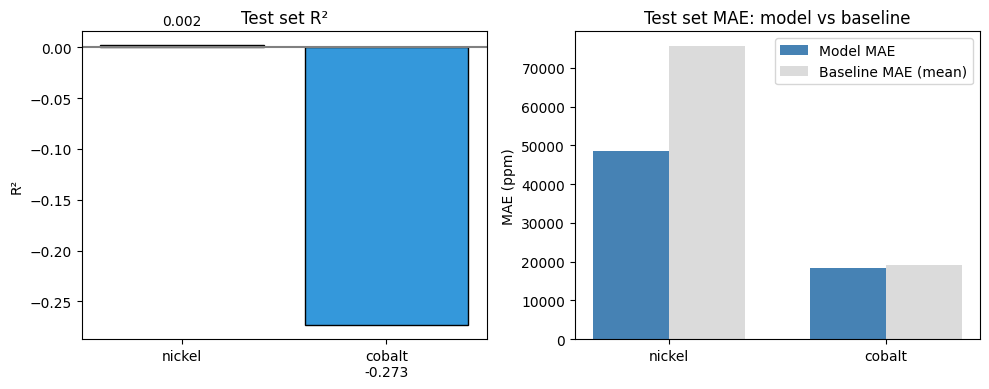

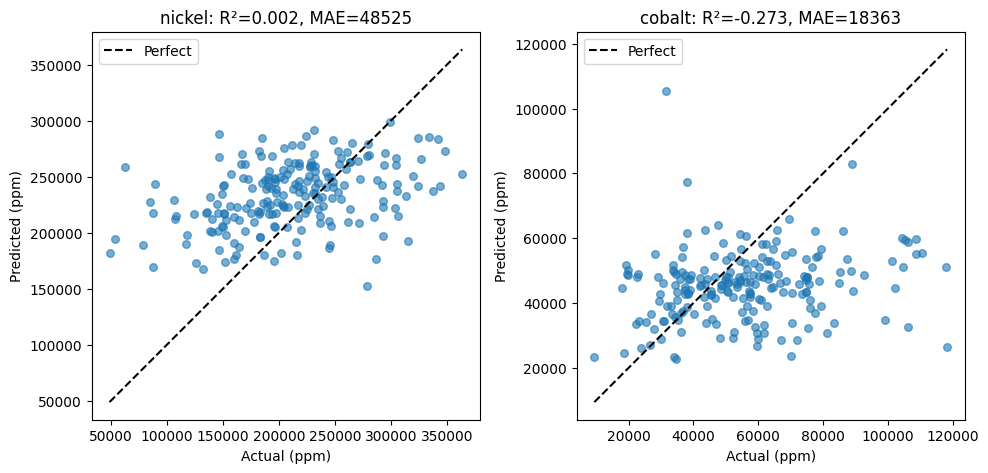

In [ ]:
# Build metrics_df (R2, MAE, MAPE, baseline MAE per target) for plotting
def mape_safe(act, pred):
    """Mean Absolute Percentage Error (%), ignoring rows where actual is 0."""
    act, pred = np.asarray(act), np.asarray(pred)
    mask = act != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((act[mask] - pred[mask]) / act[mask])) * 100
rows = []
for c in TARGETS:
    act = y_test_df[c].values
    pred = y_pred_df[c].values
    train_mean = y_train_df[c].mean()
    baseline_pred = np.full_like(act, train_mean)
    rows.append({'target': c, 'R2': r2_score(act, pred), 'MAE': mean_absolute_error(act, pred), 'MAPE': mape_safe(act, pred), 'baseline_MAE': mean_absolute_error(act, baseline_pred)})
metrics_df = pd.DataFrame(rows)
print(metrics_df.to_string())

# Plot results: R2, MAE, and actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 1) R2 bar chart
ax = axes[0]
x_pos = np.arange(len(TARGETS))
r2_vals = [metrics_df.loc[metrics_df['target'] == c, 'R2'].values[0] for c in TARGETS]
bars = ax.bar(x_pos, r2_vals, color=['#2ecc71', '#3498db'], edgecolor='black')
ax.axhline(0, color='gray', linestyle='-')
ax.set_xticks(x_pos)
ax.set_xticklabels([c.replace('_ppm', '') for c in TARGETS])
ax.set_ylabel('R²')
ax.set_title('Test set R²')
for b, v in zip(bars, r2_vals):
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02 if v >= 0 else v - 0.05, f'{v:.3f}', ha='center', fontsize=10)

# 2) MAE bar chart (model vs baseline)
ax = axes[1]
width = 0.35
mae_vals = [metrics_df.loc[metrics_df['target'] == c, 'MAE'].values[0] for c in TARGETS]
base_vals = [metrics_df.loc[metrics_df['target'] == c, 'baseline_MAE'].values[0] for c in TARGETS]
x_pos = np.arange(len(TARGETS))
ax.bar(x_pos - width/2, mae_vals, width, label='Model MAE', color='steelblue')
ax.bar(x_pos + width/2, base_vals, width, label='Baseline MAE (mean)', color='lightgray', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels([c.replace('_ppm', '') for c in TARGETS])
ax.set_ylabel('MAE (ppm)')
ax.set_title('Test set MAE: model vs baseline')
ax.legend()

plt.tight_layout()
plt.show()

# Actual vs predicted scatter per target (one plot per target)
fig2, axes2 = plt.subplots(1, 2, figsize=(10, 5))
for i, col in enumerate(TARGETS):
    ax = axes2[i]
    act = y_test_df[col].values
    pred = y_pred_df[col].values
    ax.scatter(act, pred, alpha=0.6, s=30)
    lo, hi = min(act.min(), pred.min()), max(act.max(), pred.max())
    ax.plot([lo, hi], [lo, hi], 'k--', lw=1.5, label='Perfect')
    r2 = r2_score(act, pred)
    mae = mean_absolute_error(act, pred)
    ax.set_xlabel('Actual (ppm)')
    ax.set_ylabel('Predicted (ppm)')
    ax.set_title(f"{col.replace('_ppm', '')}: R²={r2:.3f}, MAE={mae:.0f}")
    ax.legend()
    ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

<details>
<summary><strong>8. Linear regression assumption plots</strong></summary>

- **Residuals vs fitted:** Points should be roughly random around 0; a funnel shape suggests heteroscedasticity.
- **Q–Q plot:** Points should follow the line; heavy tails or S-curves suggest non-normality.
- **Actual vs predicted:** Points near the diagonal indicate good linearity; systematic curves suggest missing terms or nonlinearity.
</details>

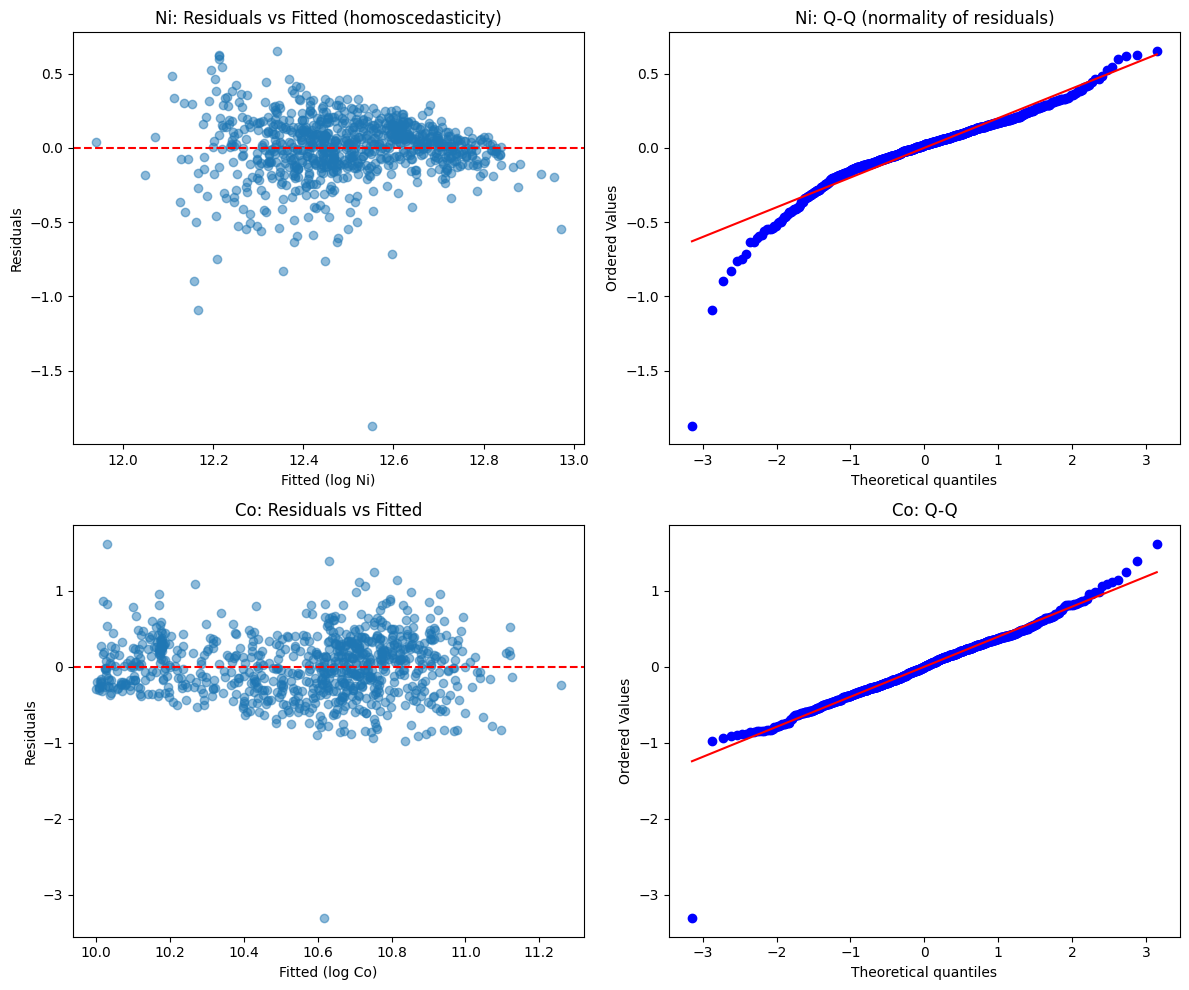

In [ ]:
# Training residuals from OLS (for assumption checks)
fitted_ni = ols_ni.fittedvalues
resid_ni = ols_ni.resid
fitted_co = ols_co.fittedvalues
resid_co = ols_co.resid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Residuals vs fitted: want random scatter around 0 (no funnel = homoscedasticity)
axes[0, 0].scatter(fitted_ni, resid_ni, alpha=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted (log Ni)')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Ni: Residuals vs Fitted (homoscedasticity)')
# Q-Q: points on line = normal residuals
stats.probplot(resid_ni, dist='norm', plot=axes[0, 1])
axes[0, 1].set_title('Ni: Q-Q (normality of residuals)')
axes[1, 0].scatter(fitted_co, resid_co, alpha=0.5)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Fitted (log Co)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Co: Residuals vs Fitted')
stats.probplot(resid_co, dist='norm', plot=axes[1, 1])
axes[1, 1].set_title('Co: Q-Q')
plt.tight_layout()
plt.show()

**Interpreting these plots**

- **Residuals vs fitted (left column):** Residuals = observed − fitted (on log scale). They should scatter randomly around 0 with **similar spread** at low and high fitted values. A funnel shape means heteroscedasticity; a curve means nonlinearity.
- **Q–Q (right column):** Sample quantiles of residuals vs normal quantiles. Points **on the red line** → residuals are normal; **tails bending away** (e.g. lower tail below the line) → heavier tails or outliers.

**Typical findings:** Ni and Co often show roughly constant residual spread (homoscedasticity OK) but **deviations in the lower tail** of the Q–Q plot — a few very negative residuals (model overpredicts) or heavier left tail than normal.

**How to address the left tail (heavy lower tail / outliers)**

1. **Identify the points:** Find rows where the residual (observed − fitted) is very negative (e.g. below −1.5 or −2 on log scale). Check whether those samples are data errors or genuine extremes.
2. **Winsorise targets:** Cap extreme low (and optionally high) values at a percentile (e.g. 1st and 99th) before modelling, so one or two extremes don’t pull the fit (already available via `WINSORIZE_TARGETS` in Step 5).
3. **Exclude outliers:** If a few points are known errors or unrepresentative, refit the model without them and compare coefficients and metrics.
4. **Robust regression:** Use a method that down-weights large residuals (e.g. `statsmodels.robust.robust_linear_model.RLM` with Huber weights) so p-values and coefficients are less sensitive to tail behaviour.
5. **Accept approximate normality:** If the main body of residuals is on the line and only the extreme tail deviates, OLS is often still reasonable for inference; interpret p-values with slight caution.

## Additional models: Random Forest, XGBoost, Gradient Boosting

Fit tree-based models on the same train/test split and features; evaluate with R², MAE, and baseline MAE (same as linear model). Predictions are in ppm (log targets converted back with expm1 when applicable).

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

def mape_safe(act, pred):
    """Mean Absolute Percentage Error (%), ignoring rows where actual is 0."""
    act, pred = np.asarray(act), np.asarray(pred)
    mask = act != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((act[mask] - pred[mask]) / act[mask])) * 100
def eval_model(y_true_ni, y_true_co, pred_ni, pred_co, y_train_df, model_name):
    """Return list of dicts: model, target, R2, MAE, MAPE, baseline_MAE."""
    rows = []
    for c, y_true, pred in [('nickel_ppm', y_true_ni, pred_ni), ('cobalt_ppm', y_true_co, pred_co)]:
        train_mean = y_train_df[c].mean()
        baseline_pred = np.full_like(y_true, train_mean)
        rows.append({
            'model': model_name, 'target': c,
            'R2': r2_score(y_true, pred),
            'MAE': mean_absolute_error(y_true, pred),
            'MAPE': mape_safe(y_true, pred),
            'baseline_MAE': mean_absolute_error(y_true, baseline_pred)
        })
    return rows

y_act_ni = y_test_df['nickel_ppm'].values
y_act_co = y_test_df['cobalt_ppm'].values
all_rows = []

# Random Forest
rf_ni = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE).fit(X_train_ni, y_train_ni)
rf_co = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE).fit(X_train_co, y_train_co)
p_ni, p_co = rf_ni.predict(X_test_ni), rf_co.predict(X_test_co)
if USE_LOG_TARGETS:
    p_ni, p_co = np.expm1(p_ni), np.expm1(p_co)
all_rows.extend(eval_model(y_act_ni, y_act_co, p_ni, p_co, y_train_df, 'RandomForest'))

# Gradient Boosting
gb_ni = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE).fit(X_train_ni, y_train_ni)
gb_co = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE).fit(X_train_co, y_train_co)
p_ni, p_co = gb_ni.predict(X_test_ni), gb_co.predict(X_test_co)
if USE_LOG_TARGETS:
    p_ni, p_co = np.expm1(p_ni), np.expm1(p_co)
all_rows.extend(eval_model(y_act_ni, y_act_co, p_ni, p_co, y_train_df, 'GradientBoosting'))

# XGBoost
xgb_ni = XGBRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE).fit(X_train_ni, y_train_ni)
xgb_co = XGBRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE).fit(X_train_co, y_train_co)
p_ni, p_co = xgb_ni.predict(X_test_ni), xgb_co.predict(X_test_co)
if USE_LOG_TARGETS:
    p_ni, p_co = np.expm1(p_ni), np.expm1(p_co)
all_rows.extend(eval_model(y_act_ni, y_act_co, p_ni, p_co, y_train_df, 'XGBoost'))

# Linear (Ridge/OLS) for comparison
all_rows.extend(eval_model(y_act_ni, y_act_co, y_pred_df['nickel_ppm'].values, y_pred_df['cobalt_ppm'].values, y_train_df, 'Linear (Ridge/OLS)'))

eval_df = pd.DataFrame(all_rows)
print('Evaluation: R2, MAE, MAPE, baseline_MAE by model and target')
print(eval_df.to_string(index=False))

Evaluation: R2, MAE, MAPE, baseline_MAE by model and target
             model     target        R2          MAE      MAPE  baseline_MAE
      RandomForest nickel_ppm  0.051041 47018.767426 27.989127  75611.191046
      RandomForest cobalt_ppm -0.242015 18689.378905 35.291184  19190.001038
  GradientBoosting nickel_ppm -0.009265 48083.158379 28.250986  75611.191046
  GradientBoosting cobalt_ppm -0.310595 19370.947276 36.560931  19190.001038
           XGBoost nickel_ppm -0.153757 51054.354973 29.264442  75611.191046
           XGBoost cobalt_ppm -0.374066 19768.568170 37.334033  19190.001038
Linear (Ridge/OLS) nickel_ppm  0.001916 48525.472181 30.257359  75611.191046
Linear (Ridge/OLS) cobalt_ppm -0.273344 18363.013001 33.763068  19190.001038
